In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score 

In [2]:
vote = pd.read_csv("../W11/county_level_election.csv")
vote.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [3]:
# "state", "county" excluded from the model
X = vote[["fipscode", "population", "hispanic", "minority", "female", "unemployed", "income", "nodegree", "bachelor", "inactivity", "obesity", "density", "cancer", "trump", "clinton"]]
y = vote["votergap"]

# train - test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Bagging / Random Forest
### 1. Set the number of estimators to be 100, the features to be the square root of available features, and iterate through depths (1-20). Use only 5 folds for cross validation to save some compute resources. Plot the max depth on the x axis and the accuracy on the y axis for training and for the mean cross validation.

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
# define two functions to run cross validation on decision tree
 
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_random_forest(X, y, tree_depths, cv=5, scoring='neg_mean_squared_error'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    
    for depth in tree_depths:
        rf_model = RandomForestRegressor(n_estimators = 100, max_depth=depth, max_features = "sqrt", random_state = 5)
        cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(rf_model.fit(X, y).score(X, y))
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [6]:
# function for plotting cross-validation results
def plot_cross_validation_on_random_forest(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation score', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    #ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    #ax.set_ylabel('Accuracy', fontsize=14)
    #ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    #ax.axvline(x=cv_scores_mean.argmax()+1, color='orange', linestyle='--') # plt.axvline(x=7, color='orange', linestyle='--')

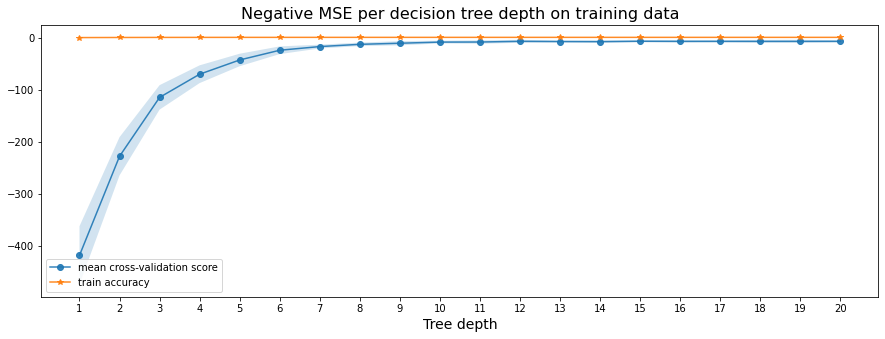

In [7]:
# fitting random forest with (negative) MSE
rf_depths = range(1, 21)
rf_cv_mean_mse, rf_cv_std_mse, rf_accuracy_mse = run_cross_validation_on_random_forest(X_train, y_train, rf_depths)

# plotting accuracy
plot_cross_validation_on_random_forest(rf_depths, rf_cv_mean_mse, rf_cv_std_mse, rf_accuracy_mse, 
                               'Negative MSE per decision tree depth on training data')

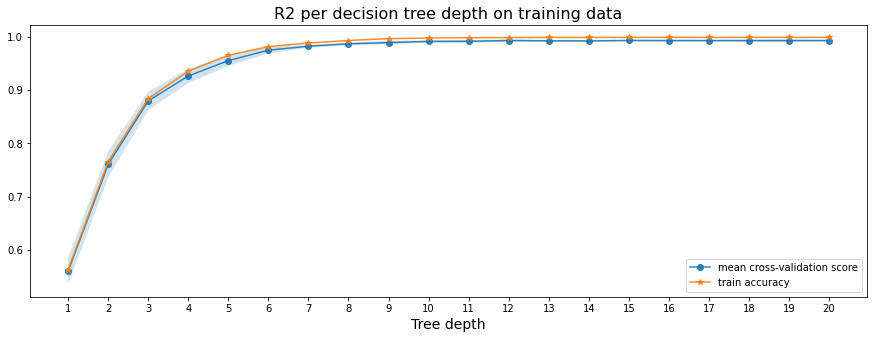

In [8]:
# fitting random forest with R2
rf_cv_mean_r2, rf_cv_std_r2, rf_accuracy_r2 = run_cross_validation_on_random_forest(X_train, y_train, rf_depths, scoring="r2")

# plotting accuracy
plot_cross_validation_on_random_forest(rf_depths, rf_cv_mean_r2, rf_cv_std_r2, rf_accuracy_r2, 
                               'R2 per decision tree depth on training data')

### 2. Based on the plot, how many nodes would you recommend as the max depth?

*I would recommend depth = 15, since this depth is corresponding to a minimal MSE or a highest R2 on the training data.*

### 3. What is the accuracy (mean cv) at your chosen depth?

In [9]:
rf_cv_mean_mse[14] # # depth starts from 1 so index for depth=15 should be 14

-6.463606897934727

In [10]:
rf_cv_mean_r2[14]

0.9932184829323202

### 4. The cross validation looks different than the lab, why?

*Different methods would identify different depth as the optimal, and the curve for cross validation scores will look differently because how they study the data will be different. Additionally, the cv grows relatively slower and smooth for random forest, probably because random forest is built on weak learners that starts with high variance, and gradually bagging to reduce the variance without much increase in bias. Random forest is more resistent to overfitting.*

## Boosting / XGBoost 
### 5. Use the defaults for most parameters. Iterate through depths (1-20). Use only 5 folds for cross validation to save some compute resources. Plot the max depth on the x axis and the accuracy on the y axis for training and for the mean cross validation.

In [11]:
import xgboost as xgb
from xgboost import XGBRegressor

In [12]:
# function 1: fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_xgboost(X, y, tree_depths, cv=5):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    
    for depth in tree_depths:
        xgbr = xgb.XGBRegressor(n_estimators = 100, verbosity=0, max_depth = depth) 
        cv_scores = cross_val_score(xgbr, X_train, y_train, cv=5)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(xgbr.fit(X, y).score(X, y))
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    
    return cv_scores_mean, cv_scores_std, accuracy_scores


# function 2: plotting cross-validation results
def plot_cross_validation_on_xgboost(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation cv score', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    #ax.set_ylabel('(Negative) Mean Squared Error', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    ax.axvline(x=cv_scores_mean.argmax()+1, color='orange', linestyle='--') # plt.axvline(x=7, color='orange', linestyle='--')

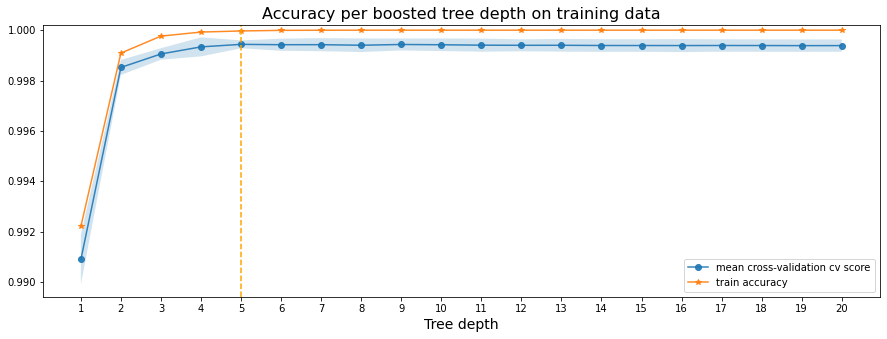

In [13]:
# fitting trees of depth 1 to 20
xgb_depths = range(1, 21)
xgb_cv_mean, xgb_cv_std, xgb_accuracy = run_cross_validation_on_xgboost(X_train, y_train, xgb_depths)

# plotting accuracy
plot_cross_validation_on_xgboost(xgb_depths, xgb_cv_mean, xgb_cv_std, xgb_accuracy, 
                               'Accuracy per boosted tree depth on training data')

### 6. Based on the plot, how many nodes would you recommend as the max depth?

*The max depth should be 5, since it is when the mean cross validation score the highest.*

### 7. What is the accuracy (mean cv) at your chosen depth?

In [14]:
xgb_cv_mean[4] # depth starts from 1 so index for depth=5 should be 4

0.9994371155340301

### 8. The cross validation looks different than random forest, why?

*Boosted tree starts with a higher cross validation score and raises quickly. This is probably due to the fact that boosted trees can capture the essential features fairly quickly (reducing bias) with additive building of tree that focuses on solving the residuals from previous tree. The goal of boosted tree is to reduce bias. It is maybe why a simpler model (smaller tree depth) would work better for the data in boosting model.*